### generating then ranking audio
- load the CNN model (or some other ranker) from feature_extraction 
- genereate parameters and its corresponding audio "randomly"
- rank the parameters using the ranker
- save the parameters that made the sound along with the rankings to some dataframe

In [133]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

from pathlib import Path

# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *
###
import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
###
import scipy.stats as ss
import common_vars as comv
import imp
import librosa
import librosa.display
import sys
sys.path.append("..")

import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
imp.reload(tm)
from helpers import *

from common_vars import SR
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['clap', 'hat', 'kick', 'rim', 'snare']

# function to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [134]:
import feature_extraction.pytorch_models as pm
import imp
imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1


#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='./feature_extraction/models/fc/env_dvn_96_41.pt'
env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()

# # freq+env model
freq_env_model_dvn = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,device=device)
state='./feature_extraction/models/fc/freq_env_dvn_97_81.pt'
freq_env_model_dvn.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=10,H2=5,H3=2)
state='./feature_extraction/models/fc/spec_fc_dvn_97.pt'
fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
state='./feature_extraction/models/cnn/clst_dvn_98_307.pt'
cnn_model_dvn.load_state_dict(torch.load(state))

#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=200,H2=100,H3=50,D_out=len(drum_groups))
state='./feature_extraction/models/fc/spec_fc_dvd_88.pt'
dvd_fc.load_state_dict(torch.load(state))

#cnn_dvd
dvd_cnn=pm.CNN_dvd(len(drum_groups))
state='./feature_extraction/models/cnn/cnn_dvd_91.pt'
dvd_cnn.load_state_dict(torch.load(state))




<All keys matched successfully>

102 1.8383715748786926
the results


env score 0.9499239325523376
fc_spec 0.888447642326355
o_cnn_spec 0.8894174098968506
fc category stacks 
 cnn category stacks
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2154e-30, 1.0000e+00]],
       grad_fn=<SoftmaxBackward>)
it took 102 iteration


<Figure size 864x216 with 0 Axes>

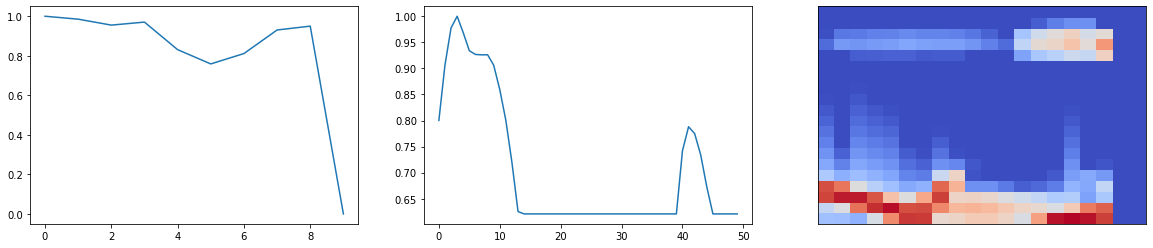

In [158]:
from IPython.display import Audio
import librosa.display

def findDrum():
    out,params= stackMaker(4)
    a= memToAud(out)
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"]
    freq_feats=freq_env_trans.call(transform_input)["feats"]
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"]
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    (ar,params,a,
    outputCNNDVD,
    outputFCDVD,
    outputE,
    outputFE,
    outputSPECFC,
    outputCNN,
    env_feats,
    freq_feats,pitch_feats)=(a,params,a,
            dvd_cnn(pitch_feats.reshape(-1,1,20,20)),
            dvd_fc(spec_flat),
            env_model_dvn(env_feats),
            freq_env_model_dvn(freq_feats),
            fc_spec_model_dvn(spec_flat),
            cnn_model_dvn(pitch_feats.reshape(-1,1,20,20)),
            env_feats,
            freq_feats,
            pitch_feats)
    
    o_e,o_fe,o_fc_spec,o_cnn_spec=outputE[0].item(),outputFE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    o_cnndvd=outputCNNDVD
    o_fcdvd=outputFCDVD
    tote=outputE[0].item()+outputSPECFC[0][0].item()
    
    argmax_index=torch.argmax(o_fcdvd).item()
    gfc=drum_groups[argmax_index]
    
    argmax_index=torch.argmax(o_cnndvd).item()
    gcnn=drum_groups[argmax_index]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    
    if o_e>0.8 and o_cnn_spec>0.8:
            print(str(i),tote)
            print("the results\n\n")
            print("env score",o_e)
            print("fc_spec",o_fc_spec)
            print("o_cnn_spec",o_cnn_spec)
            print("fc category",gfc,"\n cnn category",gcnn)
            print(o_cnndvd)
            
            return (a,env_feats,freq_feats,pitch_feats,"found")

    return (a,env_feats,freq_feats,pitch_feats,"not_found")
i=0
while True:
    i=i+1
    
    (a,env_feats,freq_feats,pitch_feats,results)=findDrum()
    if results!="not_found":
        print("it took %d iteration"%(i,))
        break

fig = plt.figure(figsize=(12,3))
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(1, 3,1)
plt.plot(env_feats)
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats[0:50])
ax=plt.subplot(1,3,3)
ft=pitch_feats
ft=ft.numpy()
librosa.display.specshow(ft[0])
Audio(a[0:25000],rate=sr, autoplay=True)

In [136]:
Path("./survey_gens/").mkdir(parents=True, exist_ok=True)


In [603]:
%%time
# from feature_extraction import mir_utils
# make a row of data and show what's going on

def makeRowSlow():
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params= stackMaker(3)
    a= memToAud(out)
   
    a,num_trimmed=cutAudio(a)
    
    dimg=z.to(device)
    h = model.init_hidden(0,device)
    h2 = tuple([e.data for e in h])
    outputs,h=model(dimg,h2)
    _, predicted = torch.max(outputs, 1)
    o=outputs.cpu().detach().numpy()[0]
    
    #normalize scores
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]), paramToDF(params)],axis=1) 
#     print(sorted(score_dict.items(), key=lambda x: x[1],reverse=True))

    return a,score_dict,params,df,z
counter=0
while True:
    counter=counter+1
    a,score_dict,params,df,image=makeRowSlow()
    s=sorted(score_dict.items(), key=lambda x: x[1],reverse=True)
    if s[0][0]!="stacks":
        print(s)
        print("after counts",counter)
        break
    
# librosa.display.waveplot(a)

Audio(a,rate=sr, autoplay=True)

NameError: name 'z' is not defined

#### here's what a row looks like, next print rows like this without the headers so we can redirect it to a csv/text file

In [185]:
%%time
from feature_extraction.mir_utils import audToImage
from helpers import *

# make a lot of rows, this can be run as its own script if you want to do multi-processing
for i in range(100):
    ## function that makes a row of parameters and the scores for the parameters 
    ## this row can then be added to a dataframe/csv file etc
    out,params=stackMaker(1)
    a=memToAud(out)
    # get the image for that audio
    try:
        im=mu.audToImage(a,128)
    except:
        pass
    z=librosa.util.normalize(im)

    #normalize array->pilform ->apply transoforms,
    z=(((z - z.min()) / (z.max() - z.min())) * 255.9).astype(np.uint8)
    zi=Image.fromarray(z)
    z=t(zi)
    images=z.reshape([1,1,120,100])

    dimg=images.to(device)
    outputs=model(dimg,)
    _, predicted = torch.max(outputs, 1)

    o=outputs.cpu().detach().numpy()[0]
    o_norm=o-min(o)
    o_norm=o_norm/sum(o_norm)
    score_dict=dict(zip(classes,o_norm))
    #ranks based on score
    ranks=1+len(classes_ranked)-ss.rankdata(o_norm) 
    rank_dict=dict(zip(classes_ranked,ranks))
    df=pd.concat([pd.DataFrame.from_dict([rank_dict]),pd.DataFrame.from_dict([score_dict]),paramToDF(params)],axis=1)    
    x=df.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
    vals = [','.join(ele.split()) for ele in x]
    
    print(df)

NameError: name 'im' is not defined